<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Objectives" data-toc-modified-id="Objectives-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objectives</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Data-Loading" data-toc-modified-id="Data-Loading-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data Loading</a></span></li></ul></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Variables-Types-and-Definitions" data-toc-modified-id="Variables-Types-and-Definitions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Variables Types and Definitions</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Target-Proportion" data-toc-modified-id="Target-Proportion-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Target Proportion</a></span></li><li><span><a href="#PLOT-1" data-toc-modified-id="PLOT-1-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>PLOT 1</a></span></li><li><span><a href="#PLOT-2" data-toc-modified-id="PLOT-2-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>PLOT 2</a></span></li><li><span><a href="#PLOT-3" data-toc-modified-id="PLOT-3-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>PLOT 3</a></span></li><li><span><a href="#PLOT-4" data-toc-modified-id="PLOT-4-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>PLOT 4</a></span></li><li><span><a href="#Correlation-Analysis" data-toc-modified-id="Correlation-Analysis-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>Correlation Analysis</a></span></li><li><span><a href="#PLOT-5" data-toc-modified-id="PLOT-5-2.2.7"><span class="toc-item-num">2.2.7&nbsp;&nbsp;</span>PLOT 5</a></span></li><li><span><a href="#PLOT-6" data-toc-modified-id="PLOT-6-2.2.8"><span class="toc-item-num">2.2.8&nbsp;&nbsp;</span>PLOT 6</a></span></li><li><span><a href="#PLOT-7" data-toc-modified-id="PLOT-7-2.2.9"><span class="toc-item-num">2.2.9&nbsp;&nbsp;</span>PLOT 7</a></span></li><li><span><a href="#PLOT-8" data-toc-modified-id="PLOT-8-2.2.10"><span class="toc-item-num">2.2.10&nbsp;&nbsp;</span>PLOT 8</a></span></li><li><span><a href="#PLOT-9" data-toc-modified-id="PLOT-9-2.2.11"><span class="toc-item-num">2.2.11&nbsp;&nbsp;</span>PLOT 9</a></span></li><li><span><a href="#PLOT-10" data-toc-modified-id="PLOT-10-2.2.12"><span class="toc-item-num">2.2.12&nbsp;&nbsp;</span>PLOT 10</a></span></li><li><span><a href="#PLOT-11" data-toc-modified-id="PLOT-11-2.2.13"><span class="toc-item-num">2.2.13&nbsp;&nbsp;</span>PLOT 11</a></span></li><li><span><a href="#PLOT-12" data-toc-modified-id="PLOT-12-2.2.14"><span class="toc-item-num">2.2.14&nbsp;&nbsp;</span>PLOT 12</a></span></li><li><span><a href="#PLOT-13" data-toc-modified-id="PLOT-13-2.2.15"><span class="toc-item-num">2.2.15&nbsp;&nbsp;</span>PLOT 13</a></span></li><li><span><a href="#PLOT-14" data-toc-modified-id="PLOT-14-2.2.16"><span class="toc-item-num">2.2.16&nbsp;&nbsp;</span>PLOT 14</a></span></li></ul></li><li><span><a href="#Encoding-/-Scaling-/-Skewness" data-toc-modified-id="Encoding-/-Scaling-/-Skewness-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Encoding / Scaling / Skewness</a></span></li><li><span><a href="#Training/Test-Split" data-toc-modified-id="Training/Test-Split-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Training/Test Split</a></span></li></ul></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Cross-Validation-Strategy" data-toc-modified-id="Cross-Validation-Strategy-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Cross Validation Strategy</a></span></li><li><span><a href="#Features-Selection" data-toc-modified-id="Features-Selection-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Features Selection</a></span></li></ul></li><li><span><a href="#Final-Metric" data-toc-modified-id="Final-Metric-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final Metric</a></span></li></ul></div>

# Bike Sharing in Washington D.C.

Statistical Programming - Python | MBD OCT 2018  
*IE School of Human Sciences and Technology*  

***

## Introduction

### Objectives

This case study of the Washington D.C Bike Sharing System aims to predict the total number of users on an hourly basis. The dataset is [available on Kaggle](https://www.kaggle.com/marklvl/bike-sharing-dataset/home). It contains usage information of years 2011 and 2012.

All the files of this project are saved in a [GitHub repository](https://github.com/ashomah/Bike-Sharing-in-Washington).

### Libraries

This project uses a set of libraries for data manipulation, ploting and modelling.

In [2]:
# Loading Libraries
import pandas as pd #Data Manipulation
import numpy as np #Data Manipulation
import datetime

import matplotlib.pyplot as plt #Plotting
import seaborn as sns #Plotting
sns.set(style='white')

from sklearn import preprocessing #Preprocessing

from scipy.stats import skew, boxcox_normmax #Preprocessing
from scipy.special import boxcox1p #Preprocessing

from sklearn.model_selection import train_test_split #Train/Test Split
from sklearn import datasets, linear_model #Model
from sklearn.linear_model import LinearRegression #Model

from sklearn.metrics import mean_squared_error, r2_score #Metrics
from sklearn.metrics import accuracy_score #Metrics
from sklearn.model_selection import cross_val_score, cross_val_predict # CV
from sklearn.feature_selection import RFE #Feature Selection



### Data Loading

The dataset is stored in the [GitHub repository](https://github.com/ashomah/Bike-Sharing-in-Washington) consisting in two CSV file: `day.csv` and `hour.csv`. The files are loaded directly from the repository.

In [3]:
hours_df = pd.read_csv("https://raw.githubusercontent.com/ashomah/Bike-Sharing-in-Washington/master/Bike-Sharing-Dataset/hour.csv")
hours_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
days_df = pd.read_csv("https://raw.githubusercontent.com/ashomah/Bike-Sharing-in-Washington/master/Bike-Sharing-Dataset/day.csv")
days_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Data Preparation

### Variables Types and Definitions

The first stage of this analysis is to describe the dataset, understand the meaning of variable and perform the necessary adjustments to ensure that the data will be proceeded correctly during the Machine Learning process.

In [5]:
# Shape of the data frame
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('hour.csv:', hours_df.shape[0],'rows |', hours_df.shape[1], 'columns'))
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('day.csv:', days_df.shape[0],'rows |', days_df.shape[1], 'columns'))

hour.csv:  17379 rows |  17 columns
day.csv:     731 rows |  16 columns


In [6]:
# Describe each variable
def df_desc(df):
    import pandas as pd
    desc = pd.DataFrame({'dtype': df.dtypes,
                         'NAs': df.isna().sum(),
                         'Numerical': (df.dtypes != 'object') & (df.dtypes != 'datetime64[ns]') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                         'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                         'Categorical': df.dtypes == 'object',
                         'Date': df.dtypes == 'datetime64[ns]',
                        })
    return desc

In [7]:
df_desc(days_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
instant,int64,0,True,False,False,False
dteday,object,0,False,False,True,False
season,int64,0,True,False,False,False
yr,int64,0,False,True,False,False
mnth,int64,0,True,False,False,False
holiday,int64,0,False,True,False,False
weekday,int64,0,True,False,False,False
workingday,int64,0,False,True,False,False
weathersit,int64,0,True,False,False,False
temp,float64,0,True,False,False,False


In [8]:
df_desc(hours_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
instant,int64,0,True,False,False,False
dteday,object,0,False,False,True,False
season,int64,0,True,False,False,False
yr,int64,0,False,True,False,False
mnth,int64,0,True,False,False,False
hr,int64,0,True,False,False,False
holiday,int64,0,False,True,False,False
weekday,int64,0,True,False,False,False
workingday,int64,0,False,True,False,False
weathersit,int64,0,True,False,False,False


The dataset `day.csv` consists in 731 rows and 16 columns. The dataset `hour.csv` consists in 17,379 rows and 17 columns. Both datasets have the same columns, with an additional column for hours in `hour.csv`.

Each row provides information for each day or each hour. None of the attributes contains any NA. Four (4) of these attributes contain decimal numbers, nine (9) contain integers, three (3) contain booleans, and one (1) contains date values stored as string.

For better readability, the columns of both data frames are renamed and data types are adjusted.

In [9]:
# HOURS DATASET
# Renaming columns names to more readable names
hours_df.rename(columns={'instant':'id',
                        'dteday':'date',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_bikes',
                        'hr':'hour',
                        'yr':'year',
                        'temp':'actual_temp',
                        'atemp':'feeling_temp'},
                inplace=True)

# Date time conversion
hours_df.date = pd.to_datetime(hours_df.date, format='%Y-%m-%d')

# Categorical variables
for column in ['season', 'holiday', 'weekday', 'workingday', 'weather_condition','month', 'year','hour']:
    hours_df[column] = hours_df[column].astype('category')
    
# DAYS DATASET
# Renaming columns names to more readable names
days_df.rename(columns={'instant':'id',
                        'dteday':'date',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_bikes',
                        'yr':'year',
                        'temp':'actual_temp',
                        'atemp':'feeling_temp'},
               inplace=True)

# Date time conversion
days_df.date = pd.to_datetime(days_df.date, format='%Y-%m-%d')

# Categorical variables
for column in ['season', 'holiday', 'weekday', 'workingday', 'weather_condition','month', 'year']:
    days_df[column] = days_df[column].astype('category')

In [10]:
hours_df.head()

,id,date,season,year,month,hour,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [11]:
hours_df.describe()

,id,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [12]:
# Lists values of categorical variables
categories = {'season': hours_df['season'].unique().tolist(),
              'year':hours_df['year'].unique().tolist(),
              'month':hours_df['month'].unique().tolist(),
              'hour':hours_df['hour'].unique().tolist(),
              'holiday':hours_df['holiday'].unique().tolist(),
              'weekday':hours_df['weekday'].unique().tolist(),
              'workingday':hours_df['workingday'].unique().tolist(),
              'weather_condition':hours_df['weather_condition'].unique().tolist(),
             }
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print()

holiday:
[0, 1]

hour:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

month:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

season:
[1, 2, 3, 4]

weather_condition:
[1, 2, 3, 4]

weekday:
[6, 0, 1, 2, 3, 4, 5]

workingday:
[0, 1]

year:
[0, 1]


In [13]:
df_desc(hours_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
hour,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False


In [14]:
days_df.head()

,id,date,season,year,month,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [15]:
days_df.describe()

,id,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [16]:
# Lists values of categorical variables
categories = {'season': days_df['season'].unique().tolist(),
              'year':days_df['year'].unique().tolist(),
              'month':days_df['month'].unique().tolist(),
              'holiday':days_df['holiday'].unique().tolist(),
              'weekday':days_df['weekday'].unique().tolist(),
              'workingday':days_df['workingday'].unique().tolist(),
              'weather_condition':days_df['weather_condition'].unique().tolist(),
             }
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print()

holiday:
[0, 1]

month:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

season:
[1, 2, 3, 4]

weather_condition:
[2, 1, 3]

weekday:
[6, 0, 1, 2, 3, 4, 5]

workingday:
[0, 1]

year:
[0, 1]


In [17]:
df_desc(days_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False
actual_temp,float64,0,True,False,False,False


The datasets contain 17 variables with no NAs:

- `id`: numerical, integer values.  
  *Record index.*
  
  
- `date`: numerical, date values.  
  *Date.*


- `season`: encoded categorical, integer between 1 and 4.  
  *Season: 1=Spring, 2=Summer, 3=Fall, 4=Winter.*


- `year`: encoded categorical, integer between 0 and 1.  
  *Year: 0=2011, 1=2012.*
  
  
- `month`: encoded categorical, integer between 1 and 12.  
  *Month.*
  
  
- `hour`: encoded categorical, integer between 1 and 23.  
  *Hour.*
  
  
- `holiday`: encoded categorical, boolean.  
  *Flag indicating if the day is a holiday.*


- `weekday`: encoded categorical, integer between 0 and 6.  
  *Day of the week (0=Sunday, ... 6=Saturday).*


- `workingday`: encoded categorical, boolean.  
  *Flag indicating if the day is a working day.*
  
  
- `weather_condition`: encoded categorical, integer between 1 and 4.  
  *Weather condition (1=Clear, 2=Mist, 3=Light Rain, 4=Heavy Rain).*


- `actual_temp`: numerical, decimal values between 0 and 1.  
  *Normalized temperature in Celsius.*


- `feeling_temp`: numerical, decimal values between 0 and 1.  
  *Normalized feeling temperature in Celsius.*


- `humidity`: numerical, decimal values between 0 and 1.  
  *Normalized humidity.*


- `windspeed`: numerical, decimal values between 0 and 1.  
  *Normalized wind speed.*


- `casual`: numerical, integer.  
  *Count of casual users.*


- `registered`: numerical, integer.  
  *Count of registered users. This variable won't be considered in the study.*


- `total_bikes`: numerical, integer.  
  *Count of total rental bikes (casual+registered). This is the __target variable__ of the study, the one to be modelled.*

### Exploratory Data Analysis

#### Target Proportion

The objective of this study is to build a model to predict the value of the variable `total_bikes`, based on the other variables available.

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


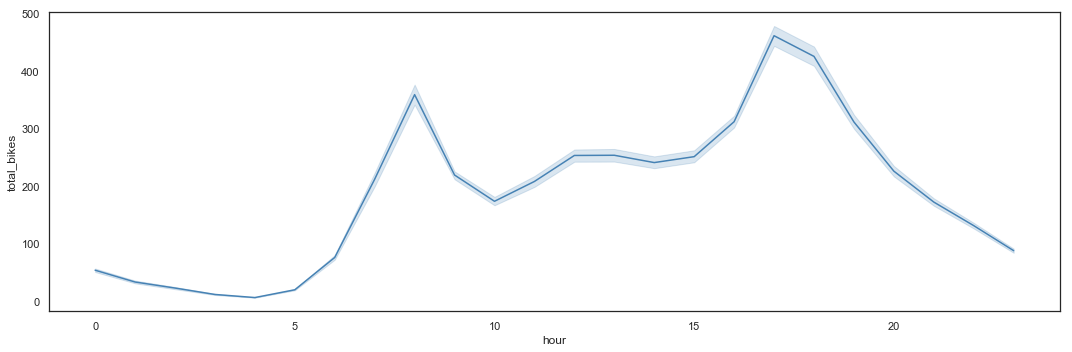

In [18]:
# Total_bikes Bar Plot from Hours
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.hour,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

#### PLOT 1

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


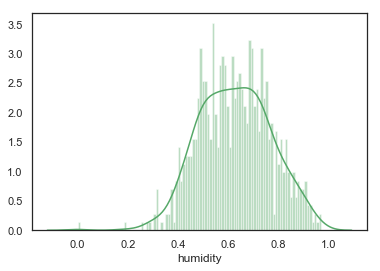

In [19]:
sns.distplot(days_df['humidity'], color='g', bins=100, hist_kws={'alpha': 0.4}) ;

#### PLOT 2

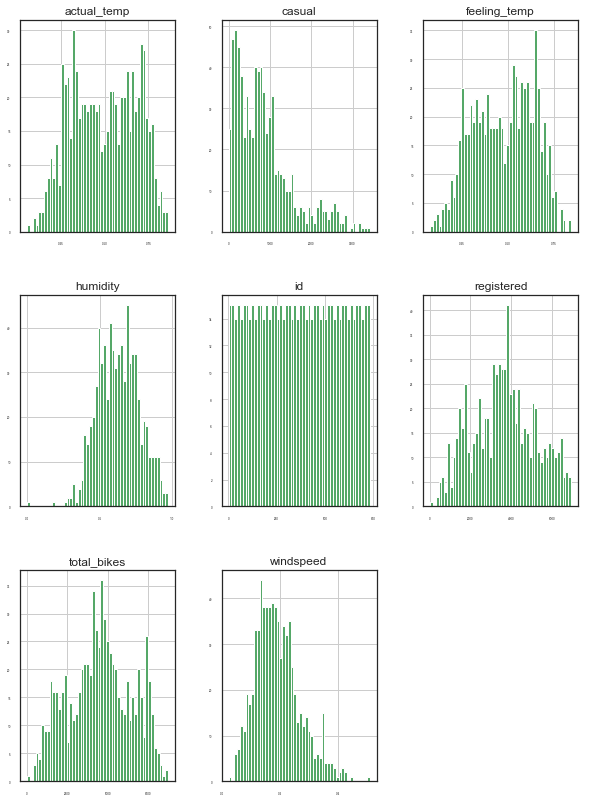

In [20]:
days_df_num = days_df.select_dtypes(include = ['float64', 'int64']);
days_df_num.hist(figsize=(10, 14), bins=50, xlabelsize=3, ylabelsize=3, color ='g');

#### PLOT 3

In [21]:
days_num_corr = days_df_num.corr()['total_bikes'][:-1] # -1 because the latest row is SalePrice
golden_features_list = days_num_corr[abs(days_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Total Bikes:\n{}".format(len(golden_features_list), golden_features_list))

There is 5 strongly correlated values with Total Bikes:
registered      0.945517
casual          0.672804
feeling_temp    0.631066
id              0.628830
actual_temp     0.627494
Name: total_bikes, dtype: float64


#### PLOT 4

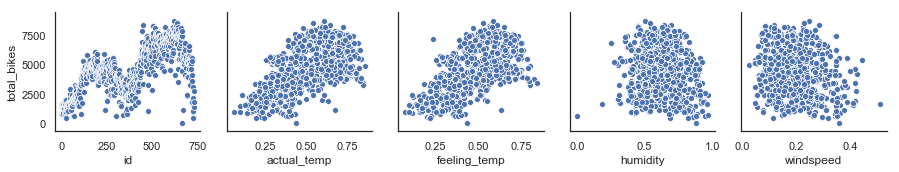

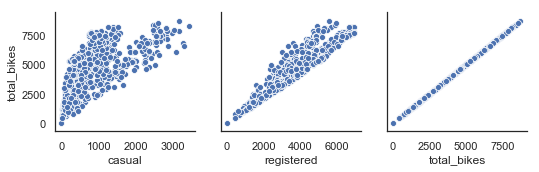

In [22]:
for i in range(0, len(days_df_num.columns), 5):
    sns.pairplot(data=days_df_num,
                x_vars=days_df_num.columns[i:i+5],
                y_vars=['total_bikes'])

#### Correlation Analysis

A correlation analysis will allow to identify relationships between the dataset variables. A plot of their distributions highlighting the value of the target variable might also reveal some patterns.

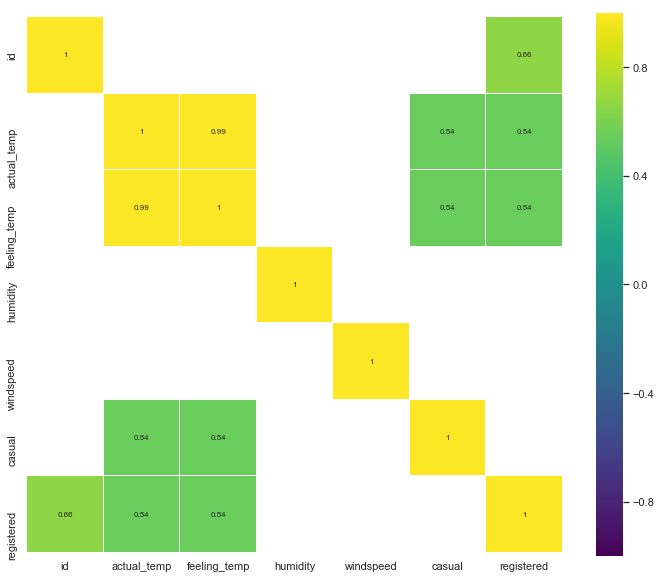

In [23]:
corr = days_df_num.drop('total_bikes', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

#### PLOT 5

/Users/stavrostsentemeidis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


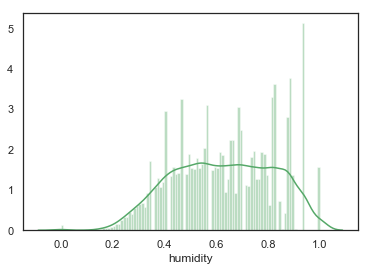

In [24]:
sns.distplot(hours_df['humidity'], color='g', bins=100, hist_kws={'alpha': 0.4}) ;

#### PLOT 6

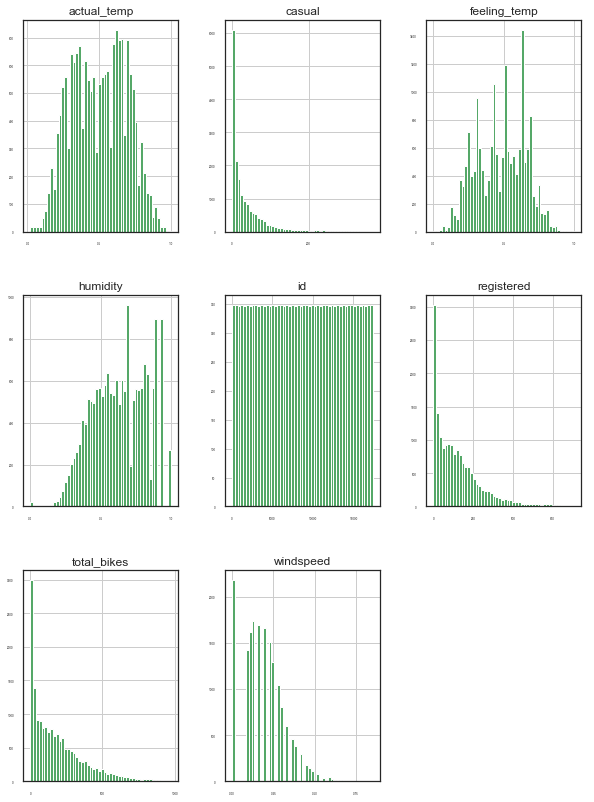

In [25]:
hours_df_num = hours_df.select_dtypes(include = ['float64', 'int64']);
hours_df_num.hist(figsize=(10, 14), bins=50, xlabelsize=3, ylabelsize=3, color='g');

#### PLOT 7

In [26]:
hours_num_corr = hours_df_num.corr()['total_bikes'][:-1] # -1 because the latest row is SalePrice
golden_features_list_1 = hours_num_corr[abs(hours_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Total Bikes:\n{}".format(len(golden_features_list_1), golden_features_list_1))

There is 2 strongly correlated values with Total Bikes:
registered    0.972151
casual        0.694564
Name: total_bikes, dtype: float64


#### PLOT 8

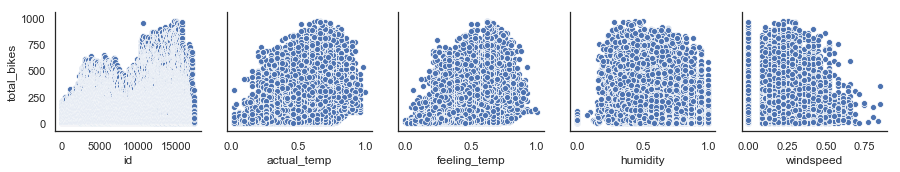

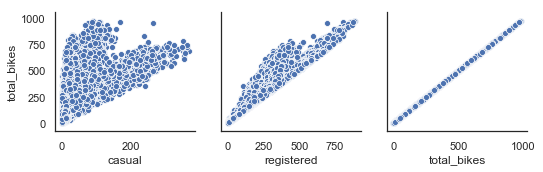

In [27]:
for i in range(0, len(hours_df_num.columns), 5):
    sns.pairplot(data=hours_df_num,
                x_vars=hours_df_num.columns[i:i+5],
                y_vars=['total_bikes'])

#### PLOT 9

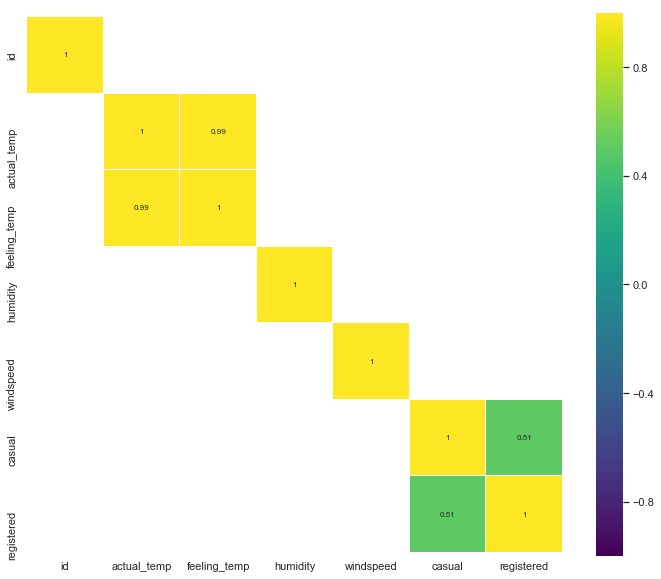

In [28]:
corr_1 = hours_df_num.drop('total_bikes', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr_1[(corr_1 >= 0.5) | (corr_1 <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

#### PLOT 10

In [29]:
hours_df_cat = hours_df.select_dtypes(include = ['category']);
hours_df_cat.head()

,season,year,month,hour,holiday,weekday,workingday,weather_condition
0,1,0,1,0,0,6,0,1
1,1,0,1,1,0,6,0,1
2,1,0,1,2,0,6,0,1
3,1,0,1,3,0,6,0,1
4,1,0,1,4,0,6,0,1


#### PLOT 11

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

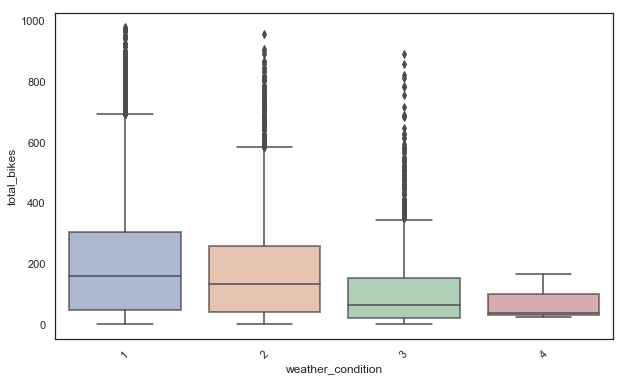

In [30]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='weather_condition', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

#### PLOT 12

(array([0, 1]), <a list of 2 Text xticklabel objects>)

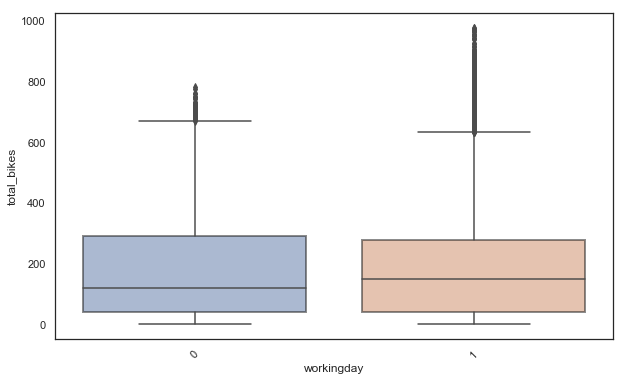

In [31]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='workingday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

#### PLOT 13

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

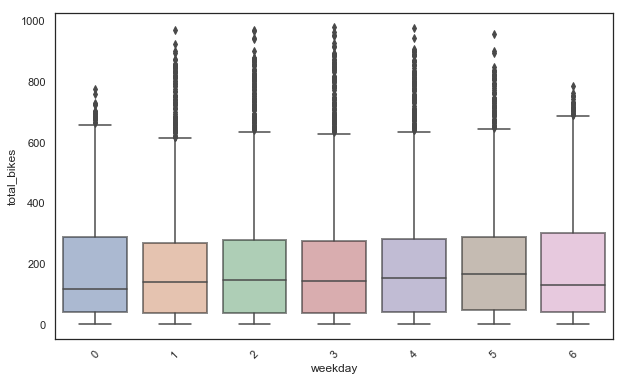

In [32]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='weekday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

#### PLOT 14

(array([0, 1]), <a list of 2 Text xticklabel objects>)

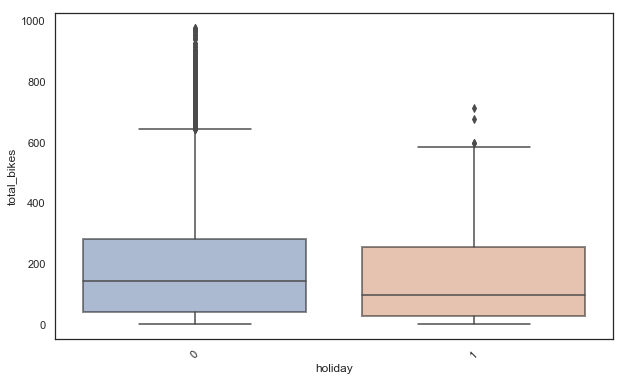

In [33]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='holiday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [34]:
hours_df.isnull().values.any()
hours_df.isnull().sum()

id                   0
date                 0
season               0
year                 0
month                0
hour                 0
holiday              0
weekday              0
workingday           0
weather_condition    0
actual_temp          0
feeling_temp         0
humidity             0
windspeed            0
casual               0
registered           0
total_bikes          0
dtype: int64

In [35]:
days_df.isnull().values.any()
days_df.isnull().sum()

id                   0
date                 0
season               0
year                 0
month                0
holiday              0
weekday              0
workingday           0
weather_condition    0
actual_temp          0
feeling_temp         0
humidity             0
windspeed            0
casual               0
registered           0
total_bikes          0
dtype: int64

In [36]:
hours_df = hours_df.drop(['registered'], axis=1)
days_df = days_df.drop(['registered'], axis=1)

### Encoding / Scaling / Skewness

In [37]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

fix_skewness(hours_df)
fix_skewness(days_df)

,id,date,season,year,month,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,total_bikes
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.120563,16.683486,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.163106,11.659472,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.163010,11.256907,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.120480,10.788111,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.134655,9.635480,1600
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.075832,9.921293,1606
6,7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.125109,12.238744,1510
7,8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.170517,8.908775,959
8,9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.203103,8.072883,822
9,10,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.152122,7.153922,1321


In [38]:
def date_features(df):
    columns = df.columns
    return df.select_dtypes(include=[np.datetime64]).columns

def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    date_columns = date_features(df)
    return(list(set(df.columns) - set(numerical_columns) - set(date_columns) ))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

hours_df_encoded = onehot_encode(hours_df)
days_df_encoded = onehot_encode(days_df)

In [ ]:
def remove_outliers(df):
    x = df.drop(['total_bikes','date'], axis=1)
    y = df.total_bikes.reset_index(drop=True)
    ols = sm.OLS(endog = y.astype(float), exog = x.astype(float))
    fit = ols.fit()
    test = fit.outlier_test()['bonf(p)']
    outliers = list(test[test<1e-3].index) 
    df.drop(df.index[outliers])
    return df

remove_outliers(hours_df)



### Training/Test Split

In [51]:
train_set = pd.DataFrame(hours_df)
X = train_set.iloc[:,:].drop(['total_bikes','date'], axis=1)
X_train = train_set.iloc[1:14491,:].drop(['total_bikes','date'], axis=1)
X_test = train_set.iloc[14492:,:].drop(['total_bikes','date'], axis=1)
X_train.head()


,id,season,year,month,hour,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual
1,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.000000,2.531634
2,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.000000,2.010221
3,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.000000,1.514787
4,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.000000,0.000000
5,6,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.084177,0.000000


In [52]:
test_set = pd.DataFrame(hours_df)
y = test_set.iloc[:,15]
y_train = test_set.iloc[1:14491,15]
y_test = test_set.iloc[14492:,15]


In [54]:
print('Features:',X.shape[0], 'items | ', X.shape[1],'columns')
print('Target:',y.shape[0], 'items | ', 1,'columns')
print('Features Train:',X_train.shape[0], 'items | ', X_train.shape[1],'columns')
print('Features Test:',X_test.shape[0], 'items | ',  X_test.shape[1],'columns')
print('Target Train:',y_train.shape[0], 'items | ', 1,'columns')
print('Target Test:',y_test.shape[0], 'items | ', 1,'columns')

Features: 17379 items |  14 columns
Target: 17379 items |  1 columns
Features Train: 14490 items |  14 columns
Features Test: 2887 items |  14 columns
Target Train: 14490 items |  1 columns
Target Test: 2887 items |  1 columns


## Baseline

In [55]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

print('Intercept:', lm.intercept_)
print('Coefficients:', lm.coef_)
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Variance score (R2): {:.2f}'.format(r2_score(y_test, y_pred)))

Intercept: 0.6495598135230978
Coefficients: [ 8.39944699e-05  1.69071013e-01  9.13607664e-01  2.06058006e-02
  1.23478540e-01  2.14150161e-01  2.95308260e-02  2.84832006e+00
 -5.07869969e-02 -2.76340683e+00 -2.17360406e+00  2.92737515e-01
  1.07202150e+00  2.77161146e+00]
Mean squared error (MSE): 12.60
Variance score (R2): 0.75


## Feature Engineering

### Cross Validation Strategy

### Features Selection

## Final Metric

***

*Vratul Kapur | Irune Maury Arrue | Paul Jacques-Mignault | Sheena Miles | Ashley O’Mahony | Stavros Tsentemeidis | Karl Westphal  
O17 (Group G) | Master in Big Data and Business Analytics | Oct 2018 Intake | IE School of Human Sciences and Technology*

***